# baseline NCA
從 **E1-1_GNCA** 簡化找到最基本的NCA架構

增加恢復能力 GNCA damage

In [69]:
# 1. 標準庫
import sys
import os
import io
import json
import glob

# 2. 第三方套件
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
import tqdm
from IPython.display import clear_output, display, HTML

# 3. 影片相關

import cv2

# 4. 設定 project 路徑（依你本機路徑調整）
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# 5. IPython 魔法指令（Jupyter專用）
%reload_ext autoreload
%autoreload 2

# 6. 共享 core_utils 函式庫導入
from core_utils.plotting import (
    plt_HWC_split_channels,
)

from core_utils.utils_io import (
    np2pil,      # numpy → PIL Image
    imwrite,     # 儲存圖像為檔案
    imencode,    # 編碼圖像為 byte stream
    im2url,      # 圖像轉 base64 URL（HTML 顯示用）
    load_emoji   # 載入 emoji 圖像
)

from core_utils.utils_image import (
    imshow,      # 在 notebook 顯示圖像
    tile2d,      # 多圖拼接
    zoom         # 放大圖像
)

from core_utils.utils_video import (
    save_video,  # 批次輸出影片
    VideoWriter  # 逐幀寫入影片（支援 context manager）
)

from core_utils.ops_tensor import (
    to_rgb,
    to_rgba,
    to_alpha
)


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E1_basicGNCA.utils.SamplePool import SamplePool

clear_output()

# Global Params

In [70]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024

TARGET_EMOJI = "🦎" #@param {type:"string"}


USE_PATTERN_POOL = True
DAMAGE_N = 3

# load data

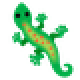

<class 'numpy.ndarray'> (40, 40, 4)


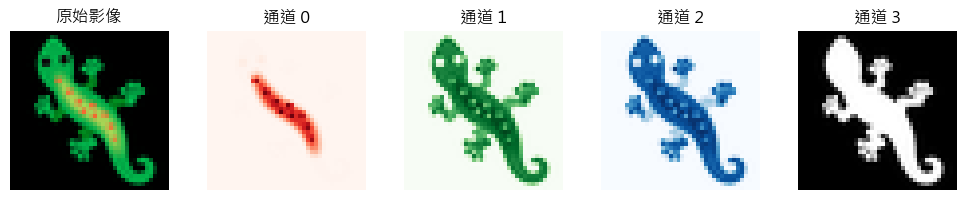

In [71]:
target_img = load_emoji(TARGET_EMOJI, max_size=TARGET_SIZE)
imshow(zoom(to_rgb(target_img), 2), fmt='png')
print(type(target_img), target_img.shape)
plt_HWC_split_channels(target_img)


# build Model

## func

In [72]:
def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

## model

In [73]:


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N):
    super().__init__()
    self.channel_n = channel_n
    self.dmodel = tf.keras.Sequential([
          layers.Conv2D(128, 1, activation=tf.nn.relu),
          layers.Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, n_times=1):
    for _ in range(n_times):
      x = self.forward_pass(x)
    return x
  
  @tf.function
  def forward_pass(self, x,angle=0.0):
    y = self.perceive(x, angle)
    dx = self.dmodel(y)
    x += dx 
    return x


CAModel().dmodel.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (1, 3, 3, 128)            6272      
                                                                 
 conv2d_61 (Conv2D)          (1, 3, 3, 16)             2064      
                                                                 
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


# Training

## make_circle_masks

In [74]:
@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask


## loss_fn

In [75]:
def loss_f(x, target=None):
  return tf.reduce_mean(tf.square(to_rgba(x)-target), [-2, -3, -1])


## init train

In [76]:
# 設定目標圖像的 padding，避免邊界效應
p = TARGET_PADDING
target = tf.pad(target_img, [[p, p], [p, p], [0, 0]])

# 取得 padding 後影像尺寸
height, width = target.shape[:2]

# 建立 NCA 初始化的種子張量 seed，shape = (H, W, CHANNEL_N)
seed = np.zeros([height, width, CHANNEL_N], dtype=np.float32)

# 種子中心設定為活性狀態（通常是 alpha 或特定通道啟動）
seed[height // 2, width // 2, 3:] = 1.0  # 3: 代表從第四個通道開始

# 建立 NCA 模型實例
ca = CAModel()

# 設定學習率與階梯衰減學習率調度器
initial_lr = 2e-3
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[2000], values=[initial_lr, initial_lr * 0.1]
)


# 建立優化器，Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 初始損失（以種子推論一次損失）
loss0 = loss_f(seed, target).numpy()

# 編譯模型以便儲存完整訓練資訊
ca.compile(optimizer=optimizer, loss=loss_f)

# 建立 SamplePool，儲存多個種子作為訓練樣本池
data={
    'x': np.repeat(seed[None, ...], POOL_SIZE, axis=0)
}
pool = SamplePool(data)


## train step

In [77]:
@tf.function
def train_step(x, target, model, loss_fn, optimizer):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    x = model(x, n_times=iter_n)
    loss = tf.reduce_mean(loss_fn(x, target))
  grads = g.gradient(loss, model.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  optimizer.apply_gradients(zip(grads, model.weights))
  return x, loss

In [78]:
def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

## run train

batch (before/after):


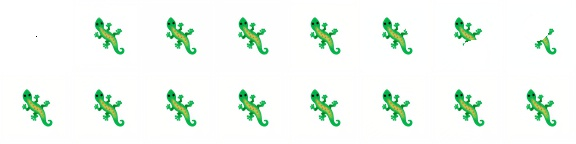

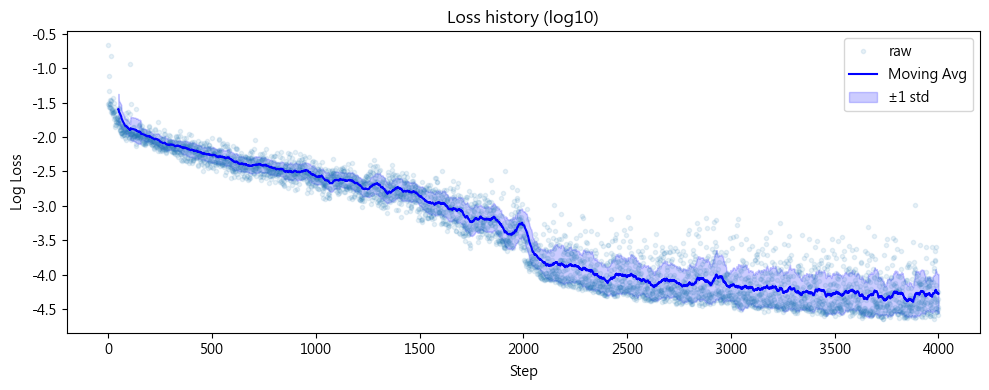

INFO:tensorflow:Assets written to: ../outputs/E1_3-GNCA/saved_model/4000\assets


INFO:tensorflow:Assets written to: ../outputs/E1_3-GNCA/saved_model/4000\assets


 step: 4002, log10(loss): -3.930

In [79]:
loss_log=[]
OUT_PATH = '../outputs/E1_3-GNCA'
EPOCHS=4000+1

for i in range(EPOCHS+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    loss_rank = loss_f(x0, target).numpy().argsort()[::-1]
    x0 = x0[loss_rank] 
    x0[:1] = seed
    h,w = x0.shape[1:3]
    
    damage = 1.0-make_circle_masks(DAMAGE_N, h=h, w=w).numpy()[..., None]
    x0[-DAMAGE_N:] *= damage
  else:
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  x, loss = train_step(x0, target, ca, loss_f, optimizer)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())
 

  if step_i%10 == 0:
    viz_pool(pool, step_i, output_path=f'{OUT_PATH}/pool')

  if step_i%100 == 0 and step_i > 0:
    clear_output()
    viz_batch(x0, x, step_i, output_path=f'{OUT_PATH}/batch')
    if step_i == EPOCHS+1:
      viz_loss(loss_log, save_path=f'{OUT_PATH}')
    else:
      viz_loss(loss_log)
    ca.save(f'{OUT_PATH}/saved_model/{step_i}')
    
  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')


# Figures

In [80]:
models = []
for i in [100, 500, 1000, 2000, 4000]:
  loaded_ca = tf.keras.models.load_model(f'{OUT_PATH}/saved_model/{i}',
                                         custom_objects={'loss_f': loss_f, 'CAModel': CAModel, 'to_rgba': to_rgba})
  models.append(loaded_ca)

out_fn = f'{OUT_PATH}/video/trained_for_differnt_steps.mp4'

# 自動建立資料夾
out_dir = os.path.dirname(out_fn)
os.makedirs(out_dir, exist_ok=True)

x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    if i%50==0:
        damage = 1.0-make_circle_masks(DAMAGE_N, h=h, w=w).numpy()[..., None]
        x[-DAMAGE_N:] *= damage
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for loaded_ca, xk in zip(models, x):
      xk[:] = loaded_ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

100%|██████████| 500/500 [00:08<00:00, 58.54it/s]


In [81]:
#@title Training Progress (Batches)
video_path = f'{OUT_PATH}/video/batches.mp4'
frames = sorted(glob.glob(f'{OUT_PATH}/batch/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile(video_path)
mvp.ipython_display(video_path)

Moviepy - Building video ../outputs/E1_3-GNCA/video/batches.mp4.
Moviepy - Writing video ../outputs/E1_3-GNCA/video/batches.mp4



Moviepy - Done !
Moviepy - video ready ../outputs/E1_3-GNCA/video/batches.mp4


In [82]:
#@title Pool Contents
video_path = f'{OUT_PATH}/video/pools.mp4'
frames = sorted(glob.glob(f'{OUT_PATH}/pool/*_pool.jpg'))[:80]
mvp.ImageSequenceClip(frames, fps=20.0).write_videofile(video_path)
mvp.ipython_display(video_path)

Moviepy - Building video ../outputs/E1_3-GNCA/video/pools.mp4.
Moviepy - Writing video ../outputs/E1_3-GNCA/video/pools.mp4



Moviepy - Done !
Moviepy - video ready ../outputs/E1_3-GNCA/video/pools.mp4
